### installations and imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import praw

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

### fetch bitcoin data and reddit news

In [14]:
start = dt.datetime.now() - dt.timedelta(days=730)
end = dt.datetime.now()

data = yf.download('BTC-USD', start=start, end=end, interval='60m')
    
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-08-20 19:00:00,21149.482422,21150.623047,20995.458984,21027.095703,21027.095703,0
2022-08-20 20:00:00,21022.779297,21130.085938,20878.296875,20889.076172,20889.076172,0
2022-08-20 21:00:00,20883.718750,21098.353516,20856.730469,21098.353516,21098.353516,511563776
2022-08-20 22:00:00,21103.009766,21212.828125,21096.333984,21141.406250,21141.406250,0
2022-08-20 23:00:00,21145.523438,21209.529297,21109.738281,21165.140625,21165.140625,0
...,...,...,...,...,...,...
2024-08-19 13:00:00,58472.601562,58966.679688,58228.832031,58237.316406,58237.316406,1191223296
2024-08-19 14:00:00,58223.628906,58537.023438,58191.140625,58537.023438,58537.023438,725917696
2024-08-19 15:00:00,58630.312500,58776.914062,58551.332031,58610.636719,58610.636719,533620736


In [15]:
reddit = praw.Reddit(client_id='-DikpAFUeeajlFFyWTBqUg',
                     client_secret='yZu1rPuBINVPuI7LuugQybGwtX1Cdg',
                     user_agent='bitcoin data')

tokenizer = BertTokenizer.from_pretrained("kk08/CryptoBERT")
sentimentModel = BertForSequenceClassification.from_pretrained("kk08/CryptoBERT")
classifier = pipeline("sentiment-analysis", model=sentimentModel, tokenizer=tokenizer)

batch_size = 24 * 7 

sentiment_data = []

for i in range(0, len(data), batch_size):
    batch_start = data.index[i]
    batch_end = data.index[min(i + batch_size - 1, len(data) - 1)]

    submissions = reddit.subreddit('cryptocurrency').search('bitcoin')

    hourly_sentiments = {hour: [] for hour in pd.date_range(start=batch_start, end=batch_end, freq='h')}

    for submission in submissions:
        post_time = dt.datetime.fromtimestamp(submission.created_utc)
        
        if batch_start <= post_time <= batch_end:
            sentiment_result = classifier(submission.title)
            sentiment_score = sentiment_result[0]['score']
            sentiment_label = sentiment_result[0]['label']
            
            if sentiment_label == 'LABEL_1':
                sentiment = sentiment_score
            else:
                sentiment = -sentiment_score
            
            post_hour = post_time.replace(minute=0, second=0, microsecond=0)
            
            if post_hour in hourly_sentiments:
                hourly_sentiments[post_hour].append(sentiment)

    for hour, sentiments in hourly_sentiments.items():
        avg_sentiment = np.mean(sentiments) if sentiments else 0
        sentiment_data.append(avg_sentiment)
    
    print(f"Processed batch {i//batch_size + 1}/{len(data)//batch_size + 1}")



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Processed batch 1/104
Processed batch 2/104
Processed batch 3/104
Processed batch 4/104
Processed batch 5/104
Processed batch 6/104
Processed batch 7/104
Processed batch 8/104
Processed batch 9/104
Processed batch 10/104
Processed batch 11/104
Processed batch 12/104
Processed batch 13/104
Processed batch 14/104
Processed batch 15/104
Processed batch 16/104
Processed batch 17/104
Processed batch 18/104
Processed batch 19/104
Processed batch 20/104
Processed batch 21/104
Processed batch 22/104
Processed batch 23/104
Processed batch 24/104
Processed batch 25/104
Processed batch 26/104
Processed batch 27/104
Processed batch 28/104
Processed batch 29/104
Processed batch 30/104
Processed batch 31/104
Processed batch 32/104
Processed batch 33/104
Processed batch 34/104
Processed batch 35/104
Processed batch 36/104
Processed batch 37/104
Processed batch 38/104
Processed batch 39/104
Processed batch 40/104
Processed batch 41/104
Processed batch 42/104
Processed batch 43/104
Processed batch 44/1

In [16]:
if len(sentiment_data) != len(data.index):
    print(f"Length mismatch: sentiment_data ({len(sentiment_data)}) vs data.index ({len(data.index)})")
    if len(sentiment_data) > len(data.index):
        sentiment_data = sentiment_data[:len(data.index)]
    else:
        sentiment_data.extend([0] * (len(data.index) - len(sentiment_data)))

data['Sentiment'] = pd.Series(sentiment_data, index=data.index[:len(sentiment_data)])

data

Length mismatch: sentiment_data (17519) vs data.index (17435)


,Open,High,Low,Close,Adj Close,Volume,Sentiment
Datetime,,,,,,,
2022-08-20 19:00:00,21149.482422,21150.623047,20995.458984,21027.095703,21027.095703,0,0.0
2022-08-20 20:00:00,21022.779297,21130.085938,20878.296875,20889.076172,20889.076172,0,0.0
2022-08-20 21:00:00,20883.718750,21098.353516,20856.730469,21098.353516,21098.353516,511563776,0.0
2022-08-20 22:00:00,21103.009766,21212.828125,21096.333984,21141.406250,21141.406250,0,0.0
2022-08-20 23:00:00,21145.523438,21209.529297,21109.738281,21165.140625,21165.140625,0,0.0
...,...,...,...,...,...,...,...
2024-08-19 13:00:00,58472.601562,58966.679688,58228.832031,58237.316406,58237.316406,1191223296,0.0
2024-08-19 14:00:00,58223.628906,58537.023438,58191.140625,58537.023438,58537.023438,725917696,0.0
2024-08-19 15:00:00,58630.312500,58776.914062,58551.332031,58610.636719,58610.636719,533620736,0.0


### prepare data

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data[['Close', 'Sentiment']].values)

prediction_hours = 24 * 7

test_days = 10
test_data_points = test_days * 24 

train_data = scaled_data[:-test_data_points]
test_data = scaled_data[-test_data_points:]

x_train, y_train = [], []

for x in range(prediction_hours, len(train_data)):
    x_train.append(train_data[x-prediction_hours:x])
    y_train.append(train_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

x_test, y_test = [], []

for x in range(prediction_hours, len(test_data)):
    x_test.append(test_data[x-prediction_hours:x])
    y_test.append(test_data[x, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (16547, 168, 2)
y_train shape: (16547,)
x_test shape: (552, 168, 2)
y_test shape: (552,)


### create and train neural network

In [18]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
518/518 [==============================] - 26s 41ms/step - loss: 0.0035
Epoch 2/25
518/518 [==============================] - 19s 37ms/step - loss: 0.0015
Epoch 3/25
518/518 [==============================] - 20s 38ms/step - loss: 0.0012
Epoch 4/25
518/518 [==============================] - 19s 37ms/step - loss: 0.0010
Epoch 5/25
518/518 [==============================] - 19s 36ms/step - loss: 9.2963e-04
Epoch 6/25
518/518 [==============================] - 19s 37ms/step - loss: 8.4815e-04
Epoch 7/25
518/518 [==============================] - 19s 36ms/step - loss: 8.1088e-04
Epoch 8/25
518/518 [==============================] - 20s 38ms/step - loss: 7.5546e-04
Epoch 9/25
518/518 [==============================] - 20s 38ms/step - loss: 7.6159e-04
Epoch 10/25
518/518 [==============================] - 21s 41ms/step - loss: 7.4890e-04
Epoch 11/25
518/518 [==============================] - 21s 40ms/step - loss: 7.3624e-04
Epoch 12/25
518/518 [==============================] - 21

### predict

In [19]:
future_hours = 24 

last_data = test_data[-prediction_hours:]

predicted_prices = []

for i in range(future_hours):
    last_data_reshaped = np.reshape(last_data, (1, last_data.shape[0], 2))
    
    predicted_price = model.predict(last_data_reshaped)
    
    predicted_prices.append(predicted_price[0, 0])
    
    new_data_point = np.array([[predicted_price[0, 0], 0]])
    last_data = np.vstack([last_data[1:], new_data_point])

predicted_prices = scaler.inverse_transform([[price, 0] for price in predicted_prices])[:, 0]

actual_prices = data['Close'][-test_data_points:][-future_hours:].values

1/1 [==============================] - 0s 37ms/step


In [20]:
predicted_prices

array([58039.56771607, 58513.98484104, 59259.15025667, 60187.10805406,
       61230.19187472, 62336.92004837, 63470.01393526, 64601.21592601,
       65706.26970252, 66761.94084681, 67745.64398554, 68637.16897267,
       69421.17349713, 70089.33735871, 70641.1357979 , 71083.18354648,
       71427.32912191, 71688.2865048 , 71881.50848191, 72021.52951084,
       72121.19239025, 72191.27540439, 72240.55446566, 72275.97573291])

In [21]:
actual_prices

array([59611.98828125, 59689.89453125, 59824.83984375, 59436.84765625,
       59378.578125  , 58482.74609375, 58391.3125    , 58548.3359375 ,
       58720.1015625 , 58751.984375  , 58587.9453125 , 58486.3671875 ,
       58603.59765625, 58522.84765625, 58616.65234375, 58028.08203125,
       58076.70703125, 58477.63671875, 58465.3671875 , 58237.31640625,
       58537.0234375 , 58610.63671875, 58715.10546875, 58857.98046875])

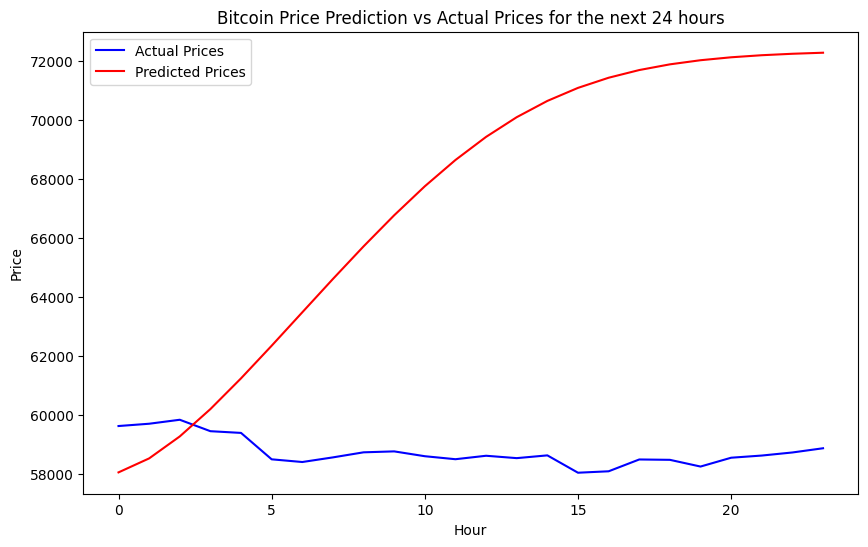

In [22]:
# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(range(future_hours), actual_prices, label='Actual Prices', color='blue')
plt.plot(range(future_hours), predicted_prices, label='Predicted Prices', color='red')
plt.title(f'Bitcoin Price Prediction vs Actual Prices for the next {future_hours} hours')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.legend()
plt.show()


In [23]:
# Calculate actual tendency (up/down) between consecutive hours
actual_tendency = np.diff(actual_prices) > 0  # True if price goes up, False if it goes down

# Calculate predicted tendency (up/down) between consecutive hours
predicted_tendency = np.diff(predicted_prices) > 0  # True if predicted price goes up, False if it goes down

# Create a DataFrame to store the results
tendency_table = pd.DataFrame({
    'Predicted Tendency': ['Up' if pred else 'Down' for pred in predicted_tendency],
    'Actual Tendency': ['Up' if actual else 'Down' for actual in actual_tendency],
    'Result': ['Correct' if correct else 'Wrong' for correct in (predicted_tendency == actual_tendency)]
})

# Add corresponding price information for better clarity
tendency_table['Price Change (Predicted)'] = [f'{predicted_prices[i]:.4f} to {predicted_prices[i+1]:.4f}' for i in range(len(predicted_prices) - 1)]
tendency_table['Price Change (Actual)'] = [f'{actual_prices[i]:.4f} to {actual_prices[i+1]:.4f}' for i in range(len(actual_prices) - 1)]

# Reorder columns for clarity
tendency_table = tendency_table[['Price Change (Predicted)', 'Price Change (Actual)', 'Predicted Tendency', 'Actual Tendency', 'Result']]

# Display the table
tendency_table



,Price Change (Predicted),Price Change (Actual),Predicted Tendency,Actual Tendency,Result
0,58039.5677 to 58513.9848,59611.9883 to 59689.8945,Up,Up,Correct
1,58513.9848 to 59259.1503,59689.8945 to 59824.8398,Up,Up,Correct
2,59259.1503 to 60187.1081,59824.8398 to 59436.8477,Up,Down,Wrong
3,60187.1081 to 61230.1919,59436.8477 to 59378.5781,Up,Down,Wrong
4,61230.1919 to 62336.9200,59378.5781 to 58482.7461,Up,Down,Wrong
5,62336.9200 to 63470.0139,58482.7461 to 58391.3125,Up,Down,Wrong
6,63470.0139 to 64601.2159,58391.3125 to 58548.3359,Up,Up,Correct
7,64601.2159 to 65706.2697,58548.3359 to 58720.1016,Up,Up,Correct
8,65706.2697 to 66761.9408,58720.1016 to 58751.9844,Up,Up,Correct
9,66761.9408 to 67745.6440,58751.9844 to 58587.9453,Up,Down,Wrong


In [24]:
# Compare tendencies
tendency_correct = actual_tendency == predicted_tendency

# Calculate the accuracy of tendency prediction
tendency_accuracy = np.mean(tendency_correct) * 100  # In percentage

# Calculate the number of correct and incorrect tendencies
correct_tendencies = np.sum(tendency_correct)
incorrect_tendencies = len(tendency_correct) - correct_tendencies

# Create a DataFrame to display the results
results_table = pd.DataFrame({
    'Metric': ['Correct Tendencies', 'Incorrect Tendencies', 'Tendency Accuracy (%)'],
    'Value': [correct_tendencies, incorrect_tendencies, f'{tendency_accuracy:.2f}%']
})

results_table


,Metric,Value
0,Correct Tendencies,13
1,Incorrect Tendencies,10
2,Tendency Accuracy (%),56.52%


In [29]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_prices, predicted_prices)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Error (MAE): {mae:.3f}')


Root Mean Squared Error (RMSE): 10012.178
Mean Absolute Error (MAE): 8772.492
